In [1]:
import scipy as sp
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy.signal import find_peaks

from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.size'] = 20

In [2]:
from newfastdigitizer2root_ygk import *

In [3]:
#dir = "/project/projectdirs/ld_tes/data/ACBias/20210916_ACBias/"
dir = "/project/projectdirs/ld_tes/data/ACBias/20210920_ACBias/"
run = "HFRun2"
partial = "_1"

In [4]:
header_info, ch_info = read_new_header_file(dir+run+".hdr")

In [5]:
header_info = parse_header_time(header_info,0)
header_info

{'Iteration number': '0',
 'Iteration time': '60',
 'Sampling Frequency': '10000000',
 'Acquired points': '250000',
 'Trigger Position': '10',
 'Trigger channel': '0',
 '# channels': '2',
 'CH0 Vertical range': '30.000000',
 'CH0 Input impedance': '1000000',
 'CH0 Probe attenuation': '1',
 'CH1 Vertical range': '0.200000',
 'CH1 Input impedance': '1000000',
 'CH1 Probe attenuation': '1',
 'BK channel': '1',
 'BK waveform': '',
 'BK amplitude': '0.000000',
 'BK offset': '0.000000',
 'BK frequency': '0.000000',
 'BK phase': '0.000000',
 'Start time UNIX': 1632176812.495564,
 'Start date': '9/20/2021',
 'Start time': '3:26:52 PM',
 'Final iteration': '6',
 'Real time': '332.456269',
 'Live time': '1.999848',
 'Trigger number': '2712',
 'Stop time UNIX': 1632177146.1676488,
 'Stop date': '9/20/2021',
 'Stop Time': '3:32:26 PM'}

In [6]:
byteFile = all_bytes_from_file(dir+run+partial+".dat")

In [7]:
parsed_data = parse_binary_data(byteFile, header_info, ch_info, endian='<')

Read 0 records
Read 10 records
Read 20 records
Read 30 records
Read 40 records
Read 50 records
Read 60 records
Read 70 records
Read 80 records
Read 90 records
Read 100 records
Read 110 records
Read 120 records
Read 130 records
Read 140 records
Read 150 records
Read 160 records
Read 170 records
Read 180 records
Read 190 records
Read 200 records
Read 210 records
Read 220 records
Read 230 records
Read 240 records
Read 250 records
Read 260 records
Read 270 records
Read 280 records
Read 290 records
Read 300 records
Read 310 records
Read 320 records
Read 330 records
Read 340 records
Read 350 records
Read 360 records
Read 370 records
Read 380 records
Read 390 records
Read 400 records
Read 410 records
Read 420 records
Read 430 records
Read 440 records
Read 450 records
Read 460 records
Read 470 records
Read 480 records


Sampling frequency = 10.0 MHz
Baseline = -2.72e-03 V


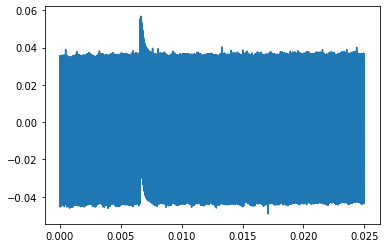

In [8]:
d0=parsed_data[0][0]['data']
d1=parsed_data[0][1]['data']
fs = float(header_info['Sampling Frequency'])
print('Sampling frequency = {0:.1f} MHz'.format(fs/1e6))

t = np.arange(len(d1))/fs

toff=0.0
tl=0.003e2
off=int(toff*fs)
l=int(tl*fs)

plt.plot(t[off:off+l],d1[off:off+l])
print('Baseline = {0:8.2e} V'.format(np.mean(d1[off:off+l])))
#plt.scatter(d0[:],d1[:],marker='.')

In [10]:
parsed_data[0]

{0: {'header': [1632176812.7273502, 0.0005391782615333796, 0, 250000],
  'data': array([ 0.37095464,  1.26814727,  1.34578894, ..., -1.08698338,
          0.27605927,  1.23363986])},
 1: {'header': [1632176812.7273502, 3.3969670312217204e-06, 1, 250000],
  'data': array([-0.0057069 , -0.00097833,  0.00195665, ..., -0.00880494,
         -0.00418506,  0.00108703])}}

Text(0, 0.5, 'Frequency spectrum (V/sqrt(Hz)')

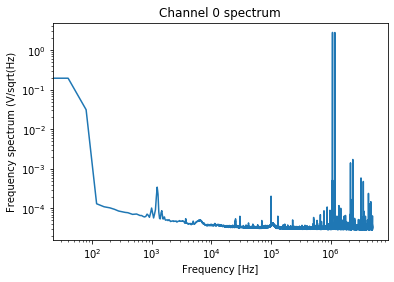

In [18]:
from scipy.signal import blackman

ch = 0
N = len(d1)
N2 = N//2
freq = fftfreq(N,1./fs)
df = freq[1]-freq[0]
w = blackman(N)

anps = np.zeros(N)
for event in parsed_data.values():
    z = fft(event[ch]['data']*w)
#    z = fft(event[ch]['data'])
    anps += np.abs(z)

anps *= 2./N/len(parsed_data)/0.42          # 0.42 for Blackman window
#anps *= 2./N/len(parsed_data)
plt.loglog(freq[0:N2], anps[0:N2])
plt.title('Channel {0:d} spectrum'.format(ch))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Frequency spectrum (V/sqrt(Hz)")

In [19]:
# find LO frequency
ipeak = find_peaks(anps[:N2],threshold=0.5)
print('Found {0:d} peaks: {1:} Hz'.format(len(ipeak[0]),freq[ipeak[0]]))
#print(freq[ipeak[0]],freq[ipeak[0][3]]-freq[ipeak[0][2]])
if0=ipeak[0][0]

# improve the precision by computing the mean frequency in small range
f0 = np.average(freq[if0-3:if0+4],weights=anps[if0-3:if0+4])
f0=freq[if0]
print('Carrier frequency = {0:.2f} Hz'.format(f0))
#print(f0)

Found 2 peaks: [1070000. 1170000.] Hz
Carrier frequency = 1070000.00 Hz


Text(0, 0.5, 'Spectrum [V/sqrt(Hz)]')

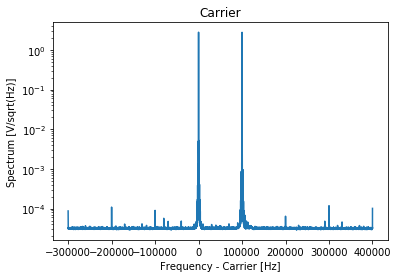

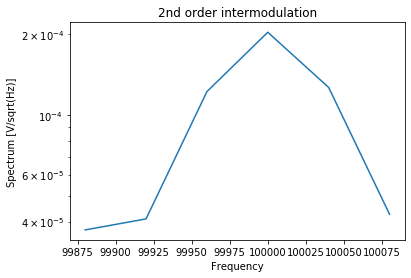

In [20]:
#plt.plot(freq[if0-300:if0+301]-f0, anps[if0-300:if0+301])
fmin=1.07e6-3e5
fmax=1.17e6+3e5
ifmin=int(fmin/df)
ifmax=int(fmax/df)

plt.plot(freq[ifmin:ifmax+1]-f0, anps[ifmin:ifmax+1])
plt.title("Carrier")
plt.yscale("log")
plt.xlabel("Frequency - Carrier [Hz]")
plt.ylabel("Spectrum [V/sqrt(Hz)]")

plt.figure()
fmin=1e5-1e2
fmax=1e5+1e2
ifmin=int(fmin/df)
ifmax=int(fmax/df)

plt.plot(freq[ifmin:ifmax+1], anps[ifmin:ifmax+1])
plt.title("2nd order intermodulation")
plt.yscale("log")
plt.xlabel("Frequency")
plt.ylabel("Spectrum [V/sqrt(Hz)]")



Text(0, 0.5, 'Frequency spectrum (V/sqrt(Hz)')

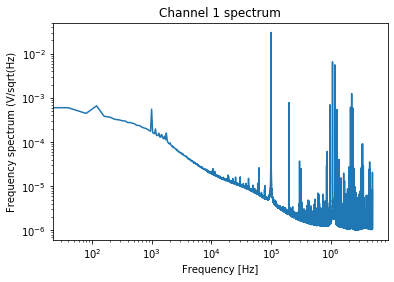

In [21]:
ch = 1

anps = np.zeros(N)
for event in parsed_data.values():
#    z = fft(event[ch]['data']*w)
    z = fft(event[ch]['data'])
    anps += np.abs(z)

#anps *= 2./N/len(parsed_data)/0.42/np.sqrt(df)          # 0.42 for Blackman window
anps *= 2./N/len(parsed_data)
plt.loglog(freq[0:N2], anps[0:N2])
plt.title('Channel {0:d} spectrum'.format(ch))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Frequency spectrum (V/sqrt(Hz)")

Text(0, 0.5, 'Spectrum [V/sqrt(Hz)]')

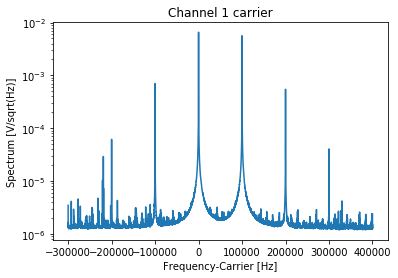

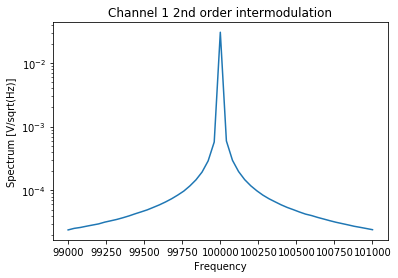

In [22]:
#plt.plot(freq[if0-300:if0+301]-f0, anps[if0-300:if0+301])
fmin=1.07e6-3e5
fmax=1.17e6+3e5
ifmin=int(fmin/df)
ifmax=int(fmax/df)

plt.plot(freq[ifmin:ifmax+1]-f0, anps[ifmin:ifmax+1])
plt.title("Channel {0:d} carrier".format(ch))
plt.yscale("log")
plt.xlabel("Frequency-Carrier [Hz]")
plt.ylabel("Spectrum [V/sqrt(Hz)]")

plt.figure()
fmin=1e5-1e3
fmax=1e5+1e3
ifmin=int(fmin/df)
ifmax=int(fmax/df)

plt.plot(freq[ifmin:ifmax+1], anps[ifmin:ifmax+1])
plt.title("Channel {0:d} 2nd order intermodulation".format(ch))
plt.yscale("log")
plt.xlabel("Frequency")
plt.ylabel("Spectrum [V/sqrt(Hz)]")
